# Trabajo práctico N°2
## Detectando lugares del mundo.

In [2]:
try:
    from PIL import Image
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


In [3]:
img_folder = r"C:\Users\Joaco\Documents\ucse\dataset\train"

# categorias propuestas
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

df = pd.DataFrame(columns=['filename', 'category'])

# Recorre cada subcarpeta
for category in categories:
    category_path = os.path.join(img_folder, category)  # Ruta completa de la subcarpeta
    for img_file in os.listdir(category_path):  # Recorre cada archivo en la subcarpeta
        if img_file.endswith(".jpg"):  # Filtra solo las imágenes con extensión .jpg
            img_path = os.path.join(category_path, img_file)  # Ruta completa de la imagen
            # Crea un DataFrame temporal con la categoría y el nombre del archivo
            temp_df = pd.DataFrame({'filename': [img_file], 'category': [category]})
            # Usa pd.concat para agregar al DataFrame principal
            df = pd.concat([df, temp_df], ignore_index=True)

# 1. Análisis exploratorio sobre el conjunto de datos.
* Volumetría de los datos: 14043 imágenes.

In [4]:
df.shape

(14034, 2)

* Estructura y tipo de las imágenes: 150x150 píxeles y están en formato .jpg

In [5]:
df.info

<bound method DataFrame.info of         filename   category
0          0.jpg  buildings
1      10006.jpg  buildings
2       1001.jpg  buildings
3      10014.jpg  buildings
4      10018.jpg  buildings
...          ...        ...
14029   9961.jpg     street
14030   9967.jpg     street
14031   9978.jpg     street
14032   9989.jpg     street
14033    999.jpg     street

[14034 rows x 2 columns]>

* Distribución de la variable a predecir: 'category'

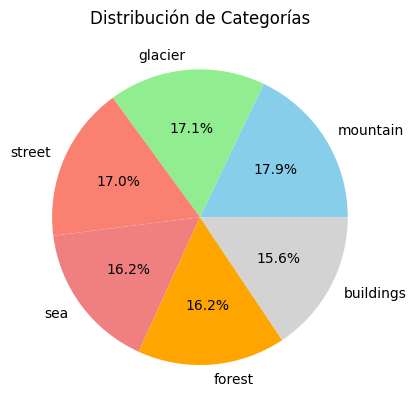

In [10]:
category_percent.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'orange', 'lightgrey'])
plt.title('Distribución de Categorías')
plt.ylabel('')
plt.show()

La distribución de las categorías en el dataset muestra un equilibrio relativamente bueno entre las diferentes clases. Cada categoría presenta una proporción similar de imágenes, lo que sugiere que el modelo de aprendizaje automático tendrá suficiente información de cada clase para aprender a diferenciarlas.

Este balance en la distribución de clases es beneficioso, ya que ayuda a prevenir problemas de sobreajuste en el modelo y permite una mejor generalización. Sin embargo, se debe monitorear el rendimiento del modelo para asegurarse de que todas las categorías sean representadas adecuadamente durante el entrenamiento.